# Data Generating Priors

In this tutorial, we will extend our Prior-Data Fitted Networks (PFNs, Muller at al. 2021) to various data-generating priors. We will consider the following priors:

- Sine-Ridge Regression
- Antisine Regression
- Gaussian Process (GP) Prior
- Bayesian Neural Network (BNN) Prior
- Structural Causal Model (SCM) Prior

The SCM prior was introduced by Hollmann et al. in 2023. Although it was not originally intended for regression tasks, we will apply it to such tasks in the same spirit as the rest of the examples. 

**Note:**
This tutorial serves as a follow-up to "Transformers Can Do Bayesian Inference" by Müller et al., 2021. For clarity and ease of use, the functions utilized in this tutorial, which remain consistent with those defined in the aforementioned work, have been consolidated into `utils.py`.


References:
- [Müller et al. (2021)](https://arxiv.org/abs/2112.10510) "Transformers Can Do Bayesian Inference."
- [Hollmann et al. (2023)](https://arxiv.org/abs/2207.01848) "TabPFN: A Transformer That Solves Small Tabular Classification Problems in a Second."


In [1]:
# basic imports
import numpy as np
import matplotlib.pyplot as plt
import math
import pathlib
import random
import sklearn.linear_model
import torch
import torch.nn as nn
from torch.nn.modules.transformer import MultiheadAttention
from torch.optim.lr_scheduler import LambdaLR

import utils
import importlib
_ = importlib.reload(utils)

if torch.cuda.is_available():
    device = torch.device("cuda")
    print("Using GPU:", device)
else:
    device = torch.device("cpu")
    print("No GPU -> using CPU:", device)

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


Using GPU: cuda


## Sine-Ridge Regression

In [2]:
def get_sine_ridge_regression(num_datasets=10, num_features=1, num_points_in_each_dataset=100, hyperparameters=None):
    if hyperparameters is None:
        hyperparameters = {'output_noise': 0.01, 'variance_weights': 1.0, 'scaling': .3}
    ws = torch.distributions.Normal(torch.zeros(num_features+1), hyperparameters['variance_weights']).sample((num_datasets,))

    xs = torch.rand(num_datasets, num_points_in_each_dataset, num_features)
    ys = torch.distributions.Normal(
        torch.einsum('nmf, nf -> nm',
                     torch.cat([xs, torch.ones(num_datasets, num_points_in_each_dataset,1)], 2),
                     ws
                    ),
        hyperparameters['output_noise']
    ).sample()
    
    ys += torch.sin(xs[...,0]*20) * hyperparameters['scaling']
    return xs, ys, ys


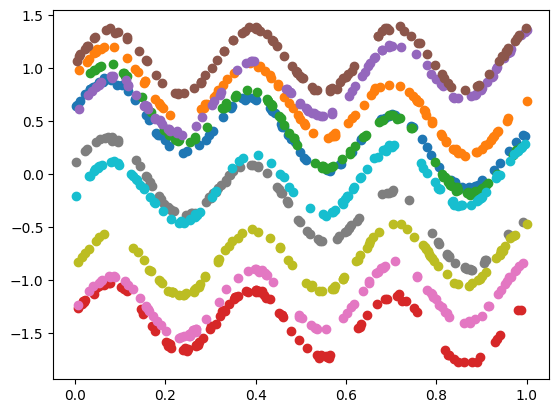

In [3]:
num_datasets = 10
num_features = 1
num_points_in_each_dataset = 100
hyperparameters = None

xs, ys, _ = get_sine_ridge_regression(num_datasets, num_features, num_points_in_each_dataset, hyperparameters)
for dataset_index in range(num_datasets):
    plt.scatter(xs[dataset_index,:,0].numpy(), ys[dataset_index].numpy())

In [4]:
num_features = 1
num_outputs = 100
num_points_in_each_dataset = 100
max_num_datasets = 16

prior_hyperparameters = {
    'variance_weights': 1.0,
    'output_noise': 0.1,
    'scaling': 0.3
}

train_parameters = {
    'epochs': 40,
    'steps_per_epoch': 100
}

model_parameters = {
    'n_out': num_outputs,
    'd_model': 256,
    'n_layers': 4,
    'n_hidden': 512,
    'n_heads': 4,
    'normalize': lambda x: (x-0.5)/math.sqrt(1/12),
}

model, dl, bucket_limits = utils.train(
    get_sine_ridge_regression, 
    num_features, 
    num_outputs, 
    num_points_in_each_dataset, 
    max_num_datasets, 
    prior_hyperparameters, 
    train_parameters, 
    model_parameters,
    device
)

/home/mila/g/guptapra/.conda/envs/llmtime/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


@Step: 0	Val loss: 1.87774	 lr: 1.000000e-04	 train_loss: 1.88718
@Step: 1000	Val loss:-0.05643	 lr: 2.739052e-06	 train_loss:-0.02596
@Step: 2000	Val loss:-0.41172	 lr: 7.033683e-04	 train_loss:-0.38229
@Step: 3000	Val loss:-0.36359	 lr: 7.938926e-04	 train_loss:-0.42318
@Step: 4000	Val loss:-0.58725	 lr: 2.739052e-06	 train_loss:-0.63985


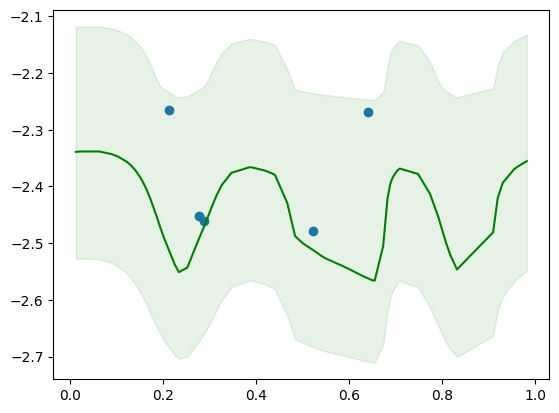

In [6]:
utils.visualize(model, dl, bucket_limits, device)

## Antisine regression

In [7]:
def get_antisine_regression(num_datasets=10, num_features=1, num_points_in_each_dataset=100, hyperparameters=None):
    if hyperparameters is None:
        hyperparameters = {'output_noise': 0.01, 'variance_weights': 1.0, 'scaling': .3}
    ws = torch.distributions.Normal(torch.zeros(num_features+1), hyperparameters['variance_weights']).sample((num_datasets,))

    xs = torch.rand(num_datasets, num_points_in_each_dataset, num_features)
    mean_ys = torch.einsum('nmf, nf -> nm',
                torch.cat([xs, torch.ones(num_datasets, num_points_in_each_dataset,1)], 2),
                ws
            )
    
    ys = torch.distributions.Normal(
        mean_ys,
        hyperparameters['output_noise']
    ).sample()
    
    ys += torch.sin(xs[...,0]*20) * hyperparameters['scaling']
    return xs, ys, mean_ys

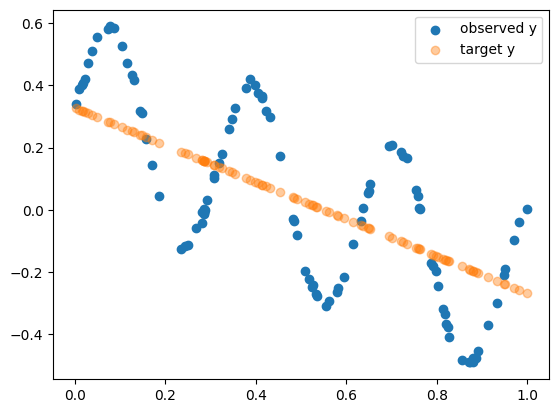

In [8]:
num_datasets = 1
num_features = 1
num_points_in_each_dataset = 100
hyperparameters = None

xs, ys, mean_ys = get_antisine_regression(num_datasets, num_features, num_points_in_each_dataset, hyperparameters)
for dataset_index in range(num_datasets):
    plt.scatter(xs[dataset_index,:,0].numpy(), ys[dataset_index].numpy(), label='observed y')
    plt.scatter(xs[dataset_index,:,0].numpy(), mean_ys[dataset_index].numpy(), alpha=0.4, label='target y')
    
plt.legend()

In [9]:
num_features = 1
num_outputs = 100
num_points_in_each_dataset = 100
max_num_datasets = 16

prior_hyperparameters = {
    'variance_weights': 1.0,
    'output_noise': 0.1,
    'scaling': 0.3
}

train_parameters = {
    'epochs': 40,
    'steps_per_epoch': 100
}

model_parameters = {
    'n_out': num_outputs,
    'd_model': 256,
    'n_layers': 4,
    'n_hidden': 512,
    'n_heads': 4,
    'normalize': lambda x: (x-0.5)/math.sqrt(1/12),
}

model, dl, bucket_limits = utils.train(
    get_antisine_regression, 
    num_features, 
    num_outputs, 
    num_points_in_each_dataset, 
    max_num_datasets, 
    prior_hyperparameters, 
    train_parameters, 
    model_parameters,
    device
)

@Step: 0	Val loss: 1.74390	 lr: 1.000000e-04	 train_loss: 1.90590
@Step: 1000	Val loss:-0.73867	 lr: 2.739052e-06	 train_loss:-0.81184
@Step: 2000	Val loss:-0.03075	 lr: 7.033683e-04	 train_loss:-0.07099
@Step: 3000	Val loss:-0.94308	 lr: 7.938926e-04	 train_loss:-1.30284
@Step: 4000	Val loss:-1.31167	 lr: 2.739052e-06	 train_loss:-1.23115


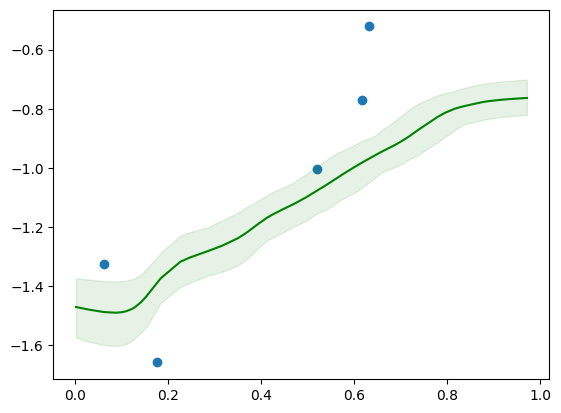

In [10]:
utils.visualize(model, dl, bucket_limits, device)

## GP Prior


*Gaussian Processes (GPs) model the distribution over all possible functions that fit a set of points.*

GPs are a generative modeling technique that describes observations in terms of a high-dimensional Gaussian distribution. For example, if we observe 5 points (x, y), we model this as a sample from a high-dimensional multivariate Gaussian distribution, where we observe only 5 points encapsulated in y1, y2, y3, y4, y5. Meanwhile, their dependence, i.e., how much influence y1 has on y5, is governed by their corresponding x1 and x5. In GPs, there are many such influences that can be utilized. These influences among various points are defined using a function called kernel functions. The most common kernel function is the Radial Basis Function (RBF).

Thus, as one can infer, the usual assumption in GPs is that the data is sampled from a high-dimensional multivariate distribution (e.g., Gaussian), of which we get to observe just a few points. Based on those points, we aim to predict the plausible ranges for the partially observed points, i.e., x's. This is exactly what our PFNs (Prior-Data Fitted Networks) aim to do - to compute the Posterior Predictive Distribution (PPD), i.e., the distribution of y given the dataset and the partially observed data. This can be done exactly in the case of tractable distributions, otherwise, approximate sampling methods are employed.

For the sake of this tutorial, we need to generate synthetic data from a GP prior. For this purpose, we will assume GP priors use the RBF kernel and multivariate Gaussian as its base distribution. Various hyperparameters associated with these parameters will also be used in the prior settings.

### Understanding GP 

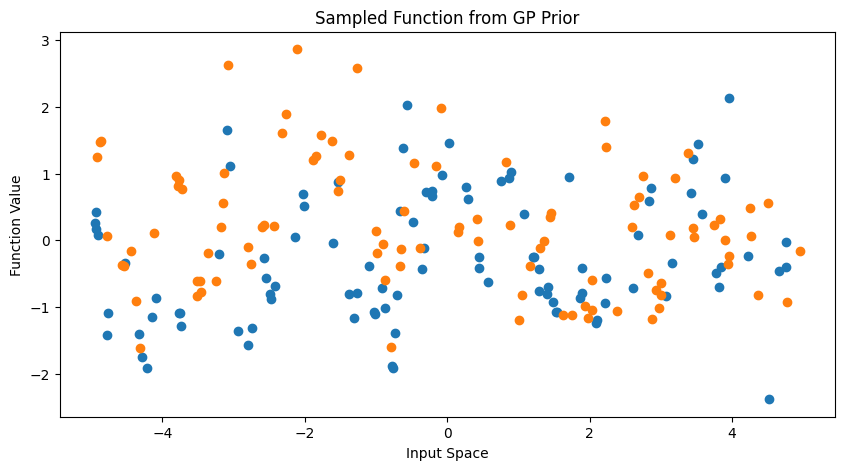

In [11]:
import numpy as np

def rbf_kernel(X1, X2, length_scale=1.0):
    """
    Compute the RBF (Gaussian) kernel between X1 and X2.
    
    :param X1: Array of m points (m x d).
    :param X2: Array of n points (n x d).
    :param length_scale: Length scale of the RBF kernel.
    :return: Covariance matrix (m x n).
    """
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return np.exp(-0.5 * sqdist / length_scale**2)

def sample_gp_prior(X, kernel_function, length_scale=1.0, signal_noise=0.0):
    """
    Sample from a Gaussian Process prior.
    
    :param X: Input locations (n x d).
    :param kernel_function: Kernel function to compute the covariance matrix.
    :param length_scale: Length scale parameter for the kernel function.
    :param noise: Noise level to add to the diagonal of the covariance matrix.
    :return: Sampled function values from the GP prior.
    """
    # Compute the covariance matrix using the provided kernel function
    K = kernel_function(X, X, length_scale) + signal_noise**2 * np.eye(len(X))
    
    # Sample from the multivariate normal distribution
    return np.random.multivariate_normal(mean=np.zeros(len(X)), cov=K)

def sample_gp_prior_with_noise(X, kernel_function, length_scale=1.0, signal_noise=0.0, observation_noise=0.1):
    """
    Sample from a Gaussian Process prior, returning both noise-free and noisy observations.
    
    :param X: Input locations (n x d).
    :param kernel_function: Kernel function to compute the covariance matrix.
    :param length_scale: Length scale parameter for the kernel function.
    :param signal_noise: Noise level to add to the diagonal of the covariance matrix for the GP prior.
    :param observation_noise: Additional noise level to simulate noisy observations.
    :return: A tuple (target_sample, sample) where target_sample represents noise-free function values, and sample includes observation noise.
    """
    # Compute the covariance matrix using the provided kernel function
    K = kernel_function(X, X, length_scale) + signal_noise**2 * np.eye(len(X))
    
    # Sample noise-free function values from the GP prior
    target_sample = np.random.multivariate_normal(mean=np.zeros(len(X)), cov=K)
    
    # Add observation noise to simulate noisy measurements
    sample = target_sample + np.random.normal(loc=0.0, scale=observation_noise, size=target_sample.shape)
    
    return target_sample, sample

### Making a GP Prior dataset

In [48]:
def get_gp_prior(num_datasets=10, num_features=1, num_points_in_each_dataset=100, hyperparameters=None):
    """
    This is a **very slow** version with sequential generation of datasets. Refer to the original code by the authors for a faster implementation that uses gpytorch.
    Link here: https://github.com/automl/PFNs/blob/main/pfns/priors/fast_gp.py
    """
    if hyperparameters is None:
        hyperparameters = {'length_scale': 1.0, 'signal_noise': 1.0, 'observation_noise': 1.0}
    
    xs = np.zeros((num_datasets, num_points_in_each_dataset, num_features))
    ys = np.zeros((num_datasets, num_points_in_each_dataset))
    target_ys = np.zeros((num_datasets, num_points_in_each_dataset))
    for i in range(num_datasets):
        xs[i] = np.random.uniform(0, 1, size=(num_points_in_each_dataset, num_features))
        t_y, y = sample_gp_prior_with_noise(
            xs[i], 
            rbf_kernel, 
            length_scale=hyperparameters['length_scale'], 
            signal_noise=hyperparameters['signal_noise'], 
            observation_noise=hyperparameters['observation_noise']
        )
        ys[i] = y
        target_ys[i] = t_y
    
    return torch.tensor(xs, dtype=torch.float32), torch.tensor(ys, dtype=torch.float32), torch.tensor(target_ys, dtype=torch.float32)

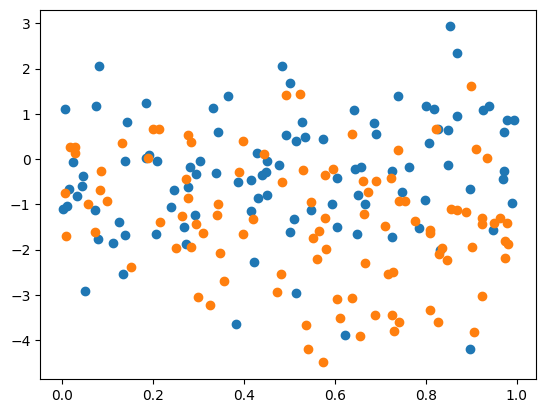

In [49]:
xs, ys, target_ys = get_gp_prior(num_datasets=2)
for i in range(xs.shape[0]):
    plt.scatter(xs[i], ys[i])

In [57]:
num_features = 1
num_outputs = 100
num_points_in_each_dataset = 100
max_num_datasets = 16

prior_hyperparameters = {
    'length_scale': 1.0, 
    'signal_noise': 0.1, 
    'observation_noise': 1.0,
    'calibrate_datasets': 10000 # a large number will make it extremely slow to begin the training
}

train_parameters = {
    'epochs': 40,
    'steps_per_epoch': 100
}

model_parameters = {
    'n_out': num_outputs,
    'd_model': 256,
    'n_layers': 4,
    'n_hidden': 512,
    'n_heads': 4,
    'normalize': lambda x: (x-0.5)/math.sqrt(1/12),
}

model, dl, bucket_limits = utils.train(
    get_gp_prior, 
    num_features, 
    num_outputs, 
    num_points_in_each_dataset, 
    max_num_datasets, 
    prior_hyperparameters, 
    train_parameters, 
    model_parameters,
    device
)

@Step: 0	Val loss: 1.76785	 lr: 1.000000e-04	 train_loss: 1.84725
@Step: 1000	Val loss: 0.06801	 lr: 2.739052e-06	 train_loss: 0.05303
@Step: 2000	Val loss: 0.13722	 lr: 7.033683e-04	 train_loss: 0.02084
@Step: 3000	Val loss:-0.00411	 lr: 7.938926e-04	 train_loss:-0.19306
@Step: 4000	Val loss:-0.01735	 lr: 2.739052e-06	 train_loss: 3.21198


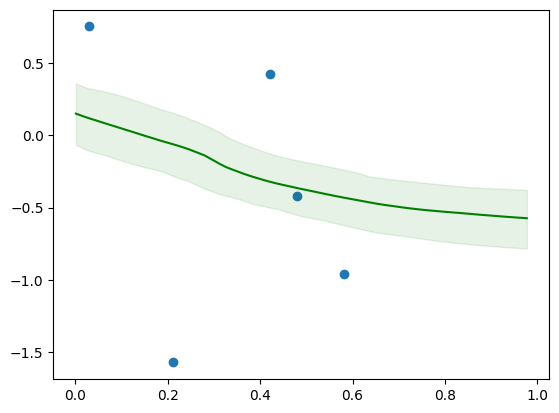

In [59]:
utils.visualize(model, dl, bucket_limits, device)

## Bayesian Neural Network (BNN) Prior

A Bayesian Neural Network (BNN) prior requires learning across a variety of neural network architectures. Consider Multilayer Perceptrons (MLPs) with varying hyperparameters, such as network depth, number of hidden units, activation functions, and dropout probabilities. BNNs aim to learn a posterior distribution over these hyperparameters in relation to the dataset. Thus, a BNN is capable of predicting a probable distribution over its outputs, essentially modeling the Posterior Predictive Distribution (PPD). Traditional methods for finding the posterior distribution over these hyperparameters, such as Stochastic Variational Inference (SVI) and Markov Chain Monte Carlo (MCMC), are computationally intensive.

Prior-Data Fitted Networks (PFNs) learn the PPD by utilizing synthetic data generated from MLPs with a range of such hyperparameters. Therefore, it is necessary to define an MLP class that can initialize the architecture as specified by the hyperparameters. This allows for the generation of synthetic data by defining a range of hyperparameters.

<img src="images/bnn.png">

In [16]:
class MLP(nn.Module):
    ACTIVATIONS = {
        'tanh': nn.Tanh(),
        'relu': nn.ReLU(),
        'elu': nn.ELU(),
        'identity': nn.Identity(),
    }
    
    def __init__(self, num_inputs, num_layers, num_hidden, num_outputs, init_std=0.1, sparseness=0.0, 
                preactivation_noise_std=0.0, activation='tanh'):
        super(MLP, self).__init__()
        self.layers = nn.ModuleList(
            [nn.Linear(num_inputs, num_hidden)] +\
            [nn.Linear(num_hidden, num_hidden) for _ in range(num_layers-2)] + \
            [nn.Linear(num_hidden, num_outputs)]
        )
        
        self.init_std = init_std
        self.sparseness = sparseness
        
        self.preactivation_noise_std = preactivation_noise_std
        self.activation = self.ACTIVATIONS[activation] 
        
        self.init_architecture()
    
    def init_architecture(self):
        for layer in self.layers:
            layer.reset_parameters()
        
        with torch.no_grad():
            for idx, linear in enumerate(self.layers):
                linear.weight.normal_(0, self.init_std)
                linear.bias.normal_(0, self.init_std)
                
                if self.sparseness > 0 and idx > 0 and idx < len(self.layers) - 1:
                    linear.weight /= (1. - self.sparseness) ** (1/2)
                    linear.weight *= torch.bernoulli(torch.ones_like(linear.weight) * (1. - self.sparseness))
                    
    def forward(self, x):
        for linear in self.layers[:-1]:
            x = linear(x)
            x = x + torch.randn_like(x) * self.preactivation_noise_std
            x = self.activation(x)
        x = self.layers[-1](x)
        return x

In [17]:
def get_bnn_prior(num_datasets=10, num_features=1, num_points_in_each_dataset=100, hyperparameters=None):
    if hyperparameters is None:
        hyperparameters = {
            'mlp_num_layers': 2, 
            'mlp_num_hidden': 64,
            'mlp_init_std': 1.0, 
            'mlp_sparseness': 0.1, 
            'mlp_output_noise': 0.1,
            'mlp_preactivation_noise_std': 0.1,
            'mlp_activation': 'relu'
        }
        
    
    # assuming normal input sampling
    xs = torch.randn(num_datasets, num_points_in_each_dataset, num_features)
    x_for_mlp = (xs - 0.5) / math.sqrt(1/12)

    model = MLP(
        num_inputs = num_features, 
        num_layers = hyperparameters['mlp_num_layers'], 
        num_hidden = hyperparameters['mlp_num_hidden'], 
        num_outputs = 1, 
        init_std = hyperparameters['mlp_init_std'],
        sparseness = hyperparameters['mlp_sparseness'],
        preactivation_noise_std = hyperparameters['mlp_preactivation_noise_std'],
        activation = hyperparameters['mlp_activation']
    )
    
    no_noise_model = MLP(
        num_inputs = num_features, 
        num_layers = hyperparameters['mlp_num_layers'], 
        num_hidden = hyperparameters['mlp_num_hidden'], 
        num_outputs = 1, 
        init_std = hyperparameters['mlp_init_std'],
        sparseness = hyperparameters['mlp_sparseness'],
        preactivation_noise_std = 0,
        activation = hyperparameters['mlp_activation']
    )
    
    ys, targets = [], []
    for x_ in x_for_mlp:
        model.init_architecture()
        x_in = x_ / math.sqrt(num_features)

        with torch.no_grad():
            y = model(x_in)
        
        ys.append(y.unsqueeze(0))
        
        # without noise target
        no_noise_model.load_state_dict(model.state_dict())
        with torch.no_grad():
            target = no_noise_model(x_in)

        targets.append(target.unsqueeze(0))
    
    ys = torch.cat(ys, dim=0).squeeze(-1)
    targets = torch.cat(targets, dim=0).squeeze(-1)
    
    noisy_ys = ys + torch.randn_like(ys) * hyperparameters['mlp_output_noise']
    return xs, noisy_ys, targets
    

/tmp/ipykernel_20536/3693400117.py:14: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xs[i], ys[i], c=color)
/tmp/ipykernel_20536/3693400117.py:15: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(xs[i], target_ys[i], c=color, alpha=0.5)


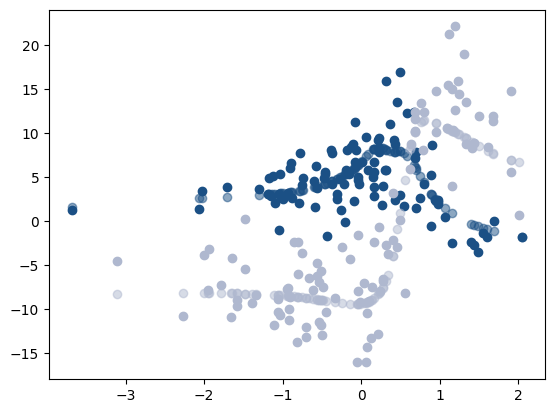

In [18]:
hyperparameters = {
    'mlp_num_layers': 2, 
    'mlp_num_hidden': 64,
    'mlp_init_std': 1.0, 
    'mlp_sparseness': 0.1, 
    'mlp_output_noise': 1.0,
    'mlp_preactivation_noise_std': 1.0,
    'mlp_activation': 'tanh'
}

xs, ys, target_ys = get_bnn_prior(num_datasets=2, hyperparameters=hyperparameters)
for i in range(xs.shape[0]):
    color = np.random.rand(3, )
    plt.scatter(xs[i], ys[i], c=color)
    plt.scatter(xs[i], target_ys[i], c=color, alpha=0.5)

In [19]:
num_features = 1
num_outputs = 100
num_points_in_each_dataset = 100
max_num_datasets = 16

prior_hyperparameters = {
    'mlp_num_layers': 2, 
    'mlp_num_hidden': 64,
    'mlp_init_std': 1.0, 
    'mlp_sparseness': 0.1, 
    'mlp_output_noise': 1.0,
    'mlp_preactivation_noise_std': 1.0,
    'mlp_activation': 'tanh',
    'calibrate_datasets': 10000 # a large number will make it extremely slow to begin the training
}

train_parameters = {
    'epochs': 40,
    'steps_per_epoch': 100
}

model_parameters = {
    'n_out': num_outputs,
    'd_model': 256,
    'n_layers': 4,
    'n_hidden': 512,
    'n_heads': 4,
    'normalize': lambda x: (x-0.5)/math.sqrt(1/12),
}

model, dl, bucket_limits = utils.train(
    get_bnn_prior, 
    num_features, 
    num_outputs, 
    num_points_in_each_dataset, 
    max_num_datasets, 
    prior_hyperparameters, 
    train_parameters, 
    model_parameters,
    device
)

@Step: 0	Val loss: 3.62282	 lr: 1.000000e-04	 train_loss: 3.42585
@Step: 1000	Val loss: 1.73481	 lr: 2.739052e-06	 train_loss: 1.81343
@Step: 2000	Val loss: 1.74478	 lr: 7.033683e-04	 train_loss: 1.83099
@Step: 3000	Val loss: 1.68611	 lr: 7.938926e-04	 train_loss: 2.07392
@Step: 4000	Val loss: 1.59237	 lr: 2.739052e-06	 train_loss: 1.59883


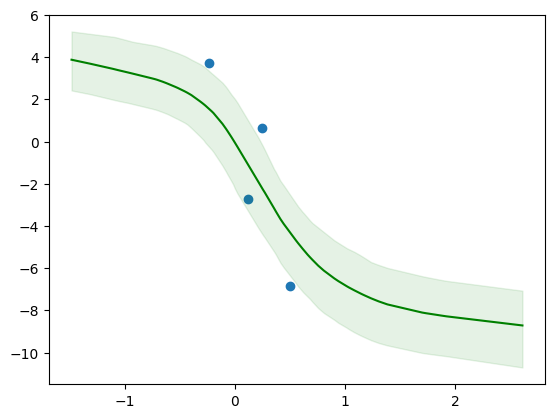

In [20]:
utils.visualize(model, dl, bucket_limits, device, 4)

## Structural Causal Model (SCM) Prior

**Note:** I am not an expert in causal reasoning. This is my attempt at understanding them as well, so please write to me if something sounds incorrect.

Causal reasoning involves estimating the causal graphs (Directed Acyclic Graphs, DAGs) that model the inputs and their impacts on the outputs. These causal relationships are identified through the use of observational data and interventions. While previous works have focused on identifying a single SCM, the authors note that this approach can be problematic, as most SCMs are not unique in the absence of intervention data.

In contrast, PFNs can consider a broad family of SCMs and their respective weights, albeit without any guarantees regarding the underlying causal structure. PFNs approximate the Posterior Predictive Distribution (PPD) directly, without considering the underlying graphical representation. Thus, PFNs can make association-based predictions on observational data, assuming SCMs as the underlying model, without having to perform full-fledged causal inference, which might also include interventions.

Defining an SCM prior is similar to defining a Bayesian Neural Network (BNN) prior, except that we randomly select intermediate nodes for xs and ys.

<img src="images/scm.png">

In [10]:
class SCM(nn.Module):
    ACTIVATIONS = {
        'tanh': nn.Tanh(),
        'relu': nn.ReLU(),
        'elu': nn.ELU(),
        'identity': nn.Identity(),
    }
    
    def __init__(self, num_outputs, num_features, hyperparameters={}):
        super(SCM, self).__init__()
        
        self.num_outputs = num_outputs
        self.num_features = num_features
        self.num_causes = hyperparameters['num_causes']
        
        n_layers = hyperparameters['num_layers']
        hidden_dim = hyperparameters['hidden_dim'] 
        
        self.layers = nn.Sequential(
            nn.Linear(self.num_causes, hidden_dim),
            *[nn.Linear(hidden_dim, hidden_dim) for _ in range(n_layers-2)],
            nn.Linear(hidden_dim, hyperparameters['num_mlp_outputs'])
        )
        
        self.activation = self.ACTIVATIONS[hyperparameters['activation']]
        self.output_noise = hyperparameters['output_noise'] # noise in intermediate activations
        self.y_is_effect = hyperparameters['y_is_effect']
        
        # dropping out connections 
        dropout_prob = max(0.01, hyperparameters['dropout'])
        init_std = hyperparameters['init_std']
        for n, p in self.layers.named_parameters():
            if p.shape == 2: # only to weights
                nn.init.normal_(p, std=init_std)
                p *= torch.bernoulli(torch.zeros_like(p) + 1. - dropout_prob)

    @torch.no_grad
    def forward(self, causes):
        num_datasets = causes.shape[0]
        outputs = [causes]
        for layer in self.layers[:-1]:
            causes = layer(outputs[-1])
            causes = self.activation(causes)
            causes = causes + torch.normal(torch.zeros_like(causes), self.output_noise)
            outputs.append(causes)
        
        final_output = self.layers[-1](outputs[-1])
        outputs.append(final_output + torch.normal(torch.zeros_like(final_output), self.output_noise))
        
        outputs, no_noise_outputs = outputs[2:], no_noise_outputs[2:]
        outputs = torch.cat(outputs, -1)
        
        # selecting x and y for synthetic data
        random_perm = [torch.randperm(outputs.shape[-1]-1, device=device).unsqueeze(0) for _ in range(num_datasets)]
        random_perm = torch.cat(random_perm, 0)
        
        # selection of outputs
        if self.y_is_effect:
            random_idx_y = list(range(-self.num_outputs, -0))
            noisy_ys = outputs[..., random_idx_y]
        else:
            random_idx_y = random_perm[..., :self.num_outputs]
            random_idx_y = random_idx_y.unsqueeze(1).expand(-1, outputs.shape[1], -1)
            noisy_ys = torch.gather(outputs, -1, random_idx_y)
            
        # selection of inputs, i.e., num_features
        random_idx_x = random_perm[..., self.num_outputs:self.num_outputs + self.num_features]
        random_idx_x = random_idx_x.unsqueeze(1).expand(-1, outputs.shape[1], -1)
        xs = torch.gather(outputs, -1, random_idx_x)

        return xs, noisy_ys, noisy_ys

In [11]:
def get_scm_prior(num_datasets=10, num_features=1, num_points_in_each_dataset=100, hyperparameters=None):
    """
    A single call generates data from the same SCM but the causes and effects vary across the samples. 
    The structure is same but the sampling of nodes from the SCM graph differ within the same call.
    """
    if hyperparameters is None:
        hyperparameters = {
            'activation': 'relu',
            'num_mlp_outputs': 10,
            'output_noise': 0.1,
            'dropout': 0.1,
            'num_layers': 4, 
            'hidden_dim': 32,
            'y_is_effect': False,
            'init_std': 0.1,
            'num_causes': 10,
        }
    
    hyperparameters['y_is_effect'] = np.random.choice([True, False])
    num_outputs=1 # we only focus on scalar regression
    
    model = SCM(num_outputs, num_features, hyperparameters=hyperparameters).to(device)
    causes = torch.randn(num_datasets, num_points_in_each_dataset, hyperparameters['num_causes'], device=device)
    xs, noisy_ys, target_ys = model(causes)
    return xs, noisy_ys.squeeze(-1), target_ys.squeeze(-1)

In [58]:
hyperparameters = {
    'activation': 'relu',
    'num_mlp_outputs': 20,
    'output_noise': 0.1,
    'dropout': 0.25,
    'num_layers': 4, 
    'hidden_dim': 64,
    'y_is_effect': False,
    'init_std': 1.0,
    'num_causes': 10
}

xs, ys, target_ys = get_scm_prior(num_datasets=1, num_features=10, hyperparameters=hyperparameters)
xs, target_ys, ys = xs.cpu().detach(), target_ys.cpu().detach(), ys.cpu().detach()

In [57]:
num_features = 10 # number of columns in the dataset
num_outputs_class = 100
num_points_in_each_dataset = 100
max_num_datasets = 16

prior_hyperparameters = {
    'activation': 'relu',
    'num_mlp_outputs': 20,
    'output_noise': 0.1,
    'dropout': 0.5,
    'num_layers': 4, 
    'hidden_dim': 64,
    'y_is_effect': False,
    'init_std': 1.0,
    'num_causes': 10,
    'calibrate_datasets': 10000 # a large number will make it extremely slow to begin the training
}


train_parameters = {
    'epochs': 40,
    'steps_per_epoch': 100
}

model_parameters = {
    'n_out': num_outputs_class,
    'd_model': 256,
    'n_layers': 4,
    'n_hidden': 512,
    'n_heads': 4,
    'normalize': lambda x: x,
}

model, dl, bucket_limits = utils.train(
    get_scm_prior, 
    num_features, 
    num_outputs_class, 
    num_points_in_each_dataset, 
    max_num_datasets, 
    prior_hyperparameters, 
    train_parameters, 
    model_parameters,
    device
)

@Step: 0	Val loss:-0.47051	 lr: 1.000000e-04	 train_loss:-0.49495
@Step: 1000	Val loss:-0.90995	 lr: 2.739052e-06	 train_loss:-2.14803
@Step: 2000	Val loss:-0.28657	 lr: 7.033683e-04	 train_loss:-0.51018
@Step: 3000	Val loss:-0.40777	 lr: 7.938926e-04	 train_loss:-0.44104
@Step: 4000	Val loss:-0.60237	 lr: 2.739052e-06	 train_loss:-2.02580


**Note:** Above is only for illustration purposes. Hollman et al. 2023 uses SCM and BNNs together for tabular datasets on classification tasks. 